# Регрессия

In [100]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams.update({"font.size": 16})


def generate_problem(function, a, b, randomize_x=False, noise=None, n=50):               
    x = np.random.uniform(low=a, high=b, size=n) if randomize_x else  np.linspace(a, b, n)
    y = function(x)
    if noise:
        y += np.random.normal(loc=0., scale=noise, size=n)
    return pd.DataFrame({
        "x": x,
        "y": y
    })

def plot_regression_problem(ax, data, regressor=None, test_data=None):
    # dataset column
    if test_data is None:
        data = data.copy()
        data["dataset"] = "train"
    else:
        data = pd.concat([data, test_data], keys=["train", "test"])
        data = data.reset_index(level=0).rename(columns={"level_0": "dataset"})
    
    # scatter
    ax.set_ylim([
        data["y"].min() - 0.1,
        data["y"].max() + 0.1
    ])
    sns.scatterplot(data=data, x="x", y="y", hue="dataset", ax=ax)
    
    # regressor
    if regressor: 
        x_min, x_max = data["x"].min(), data["x"].max()
        x = np.linspace(x_min, x_max, 100)
        y = regressor(x)
        sns.lineplot(x=x, y=y, color="green", ax=ax)

## Аппроксимация полиномами

Рассмотрим задачу аппроксимации неизвестной функции одного аргумента. Пусть имеется набор из $N$ точек  $(x_i, y_i) \in\mathbb{R}, \, i=1,\ldots, N$ и перед нами стоит цель найти функцию $f\colon \mathbb{R}\to\mathbb{R}$, которая бы хорошо аппроксимировала имеющиеся точки. Для этого можно поставить задачу поиска функции $f$ из класса $F$ с наименьшей среднеквадратичной ошибкой

$$
\dfrac1N\sum_{i=1}^N(f(x_i) - y_i)^2 \sim \min\limits_{f\in F}.
$$

В ячейке ниже генерируется набор таких точек.
- значения $x_i$ генерируются на равномерной сетке на отрезке $[0, 4]$;
- значения $y_i$ генерируются в качестве значения полинома $y_i = f(x_i) = 1 - \dfrac{x_i^2}{2!} + \dfrac{x_i^4}{4!}$.

,x,y,dataset
0,0.00,1.00,train
1,0.08,1.00,train
2,0.16,0.99,train
3,0.24,0.97,train
4,0.33,0.95,train


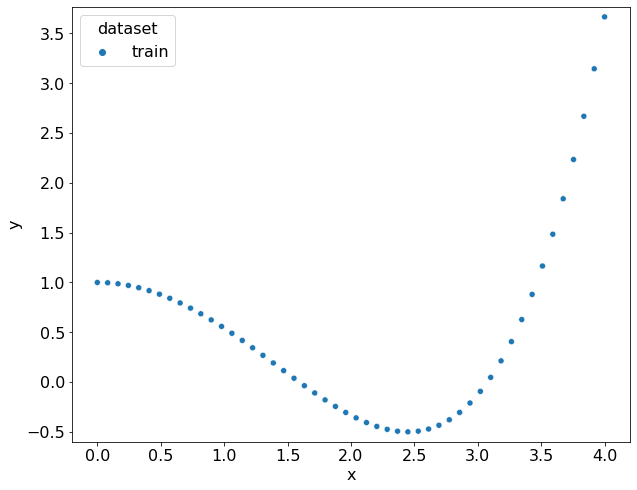

In [74]:
from math import factorial
from numpy.polynomial.polynomial import Polynomial

coef = [
    1,                  # 1 
    0,                  # x
    -1./factorial(2),   # x^2
    0,                  # x^3
    1./factorial(4)     # x^4
]
f = Polynomial(coef)

data = generate_problem(f, 0, 4)
fig, ax = plt.subplots(figsize=(10, 8))
plot_regression_problem(ax, data)

data.head()

Если в качестве $F$ выбрать вообще любые функции, то можно легко найти функцию, которая будет проходить через каждую точку. Ограничимся пока полиномами $n$-й степени

$$
P_n(a, x) = a_0 + a_1 x + \ldots + a_n x^n,  
$$

где $a=\{a_0, \ldots, a_n\}$ --- набор коэффициентов полинома. Тогда задача поиска полинома с наименьшей среднеквадратичной ошибкой сводится в подбору коэффициентов $a$ методом наименьших квадратов:

$$
\dfrac1N\sum_{i=1}^N(P_n(a, x_i) - y_i)^2 \sim \min\limits_{a\in\mathbb{R}^{n+1}}.
$$

Функция [numpy.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) позволяет решить именно эту задачу. В ячейке ниже с помощью этого метода удаётся найти хорошую аппроксимацию для этих точек. 

x^0:	+1.0000 	 +1.0000
x^1:	+0.0000 	 -0.0000
x^2:	-0.5000 	 -0.5000
x^3:	+0.0000 	 -0.0000
x^4:	+0.0417 	 +0.0417


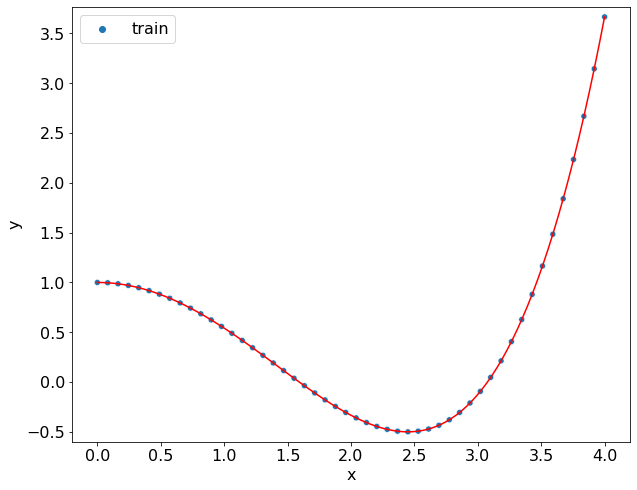

In [75]:
def polynomial_regression(data, degree):
    coefficients = np.polyfit(data["x"], data["y"], degree)
    return Polynomial(coef=coefficients[::-1])

polynomial = polynomial_regression(data, 4)

fig, ax = plt.subplots(figsize=(10, 8))
plot_regression_problem(ax, data, polynomial)

for i, (c, c_) in enumerate(zip(coef, polynomial.coef)):
    print(f"x^{i}:\t{c:+.4f} \t {c_:+.4f}")

## Линейная регрессия

Пусть $X$ --- [матрица Вандермонда](https://en.wikipedia.org/wiki/Vandermonde_matrix) для $x$ координат точек выборки

$$
X=
\begin{pmatrix}
1 & x_1 & \cdots & x_1^n \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_N & \cdots & x_N^n  
\end{pmatrix},
$$

$Y$ --- столбец $y$ координат точек выборки

$$
Y = 
\begin{pmatrix}
y_1 \\
\vdots \\ 
y_n
\end{pmatrix},
$$

а $a$ --- столбец коэффициентов полинома

$$
a = 
\begin{pmatrix}
a_0 \\
a_1 \\
\vdots \\ 
a_n
\end{pmatrix}.
$$

Тогда матричное уравнение $X a = Y$ будет соответствовать системе

$$
\begin{cases}
a_0 + a_1 x_1 + \ldots + a_n x_1^n = y_1, \\
\cdots \\ 
a_0 + a_1 x_N + \ldots + a_n x_N^n = y_N,
\end{cases}
$$

квадрат невязки которой $\|X\omega - Y\|^2$ с точностью до множителя равен среднеквадратичной ошибке полинома с коэффициентами $\{a_0,\ldots, a_n\}$. Эту задачу можно считать линейной регрессией:
- регрессия, потому оценивается действительнозначный параметр;
- линейная, потому-что параметры модели входят линейно.

В терминах машинного обучения матрица $X$ --- матрица признаков, каждая строка которой соответствует признаковому описанию одной точки, $Y$ --- матрица целевых признаков, а  $a$ --- веса модели. Класс [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) позволяет решать задачу полиномиальной регрессии. Его метод `fit` принимает на вход матрицу признаков $X$ и целевых признаков $Y$ и подбирает коэффициенты методом МНК.

В ячейке ниже переопределяется функция `polynomial` на основе этого класса. В данном случае приходится явно генерировать матрицу Вандермонда, чтобы задать матрицу признаков. 

x^0:	+1.0000 	 +1.0000
x^1:	+0.0000 	 -0.0000
x^2:	-0.5000 	 -0.5000
x^3:	+0.0000 	 -0.0000
x^4:	+0.0417 	 +0.0417


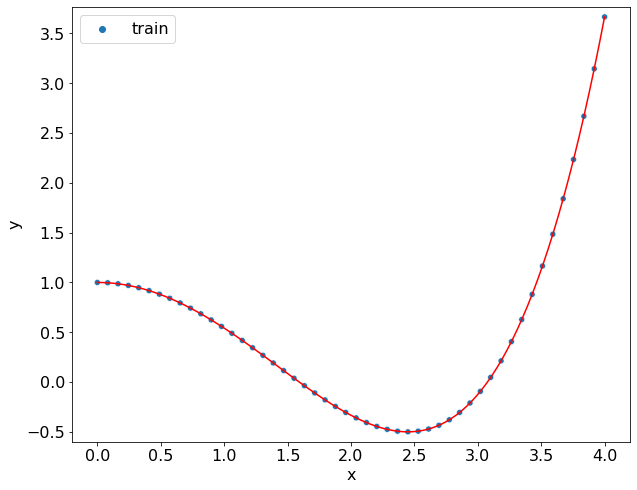

In [76]:
from sklearn.linear_model import LinearRegression

def polynomial_regression(data, degree):
    X = np.vander(data["x"], N=degree + 1, increasing=True)
    y = data["y"]

    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(X, y)
    return Polynomial(regressor.coef_)

polynomial = polynomial_regression(data, 4)

fig, ax = plt.subplots(figsize=(10, 8))
plot_regression_problem(ax, data, polynomial)

for i, (c, c_) in enumerate(zip(coef, polynomial.coef)):
    print(f"x^{i}:\t{c:+.4f} \t {c_:+.4f}")

Получили тоже самое решение. Посмотрим влияние степени полинома.

        x^0     x^1     x^2     x^3    x^4     x^5
0    0.2699     NaN     NaN     NaN    NaN     NaN
1    0.2699  0.0000     NaN     NaN    NaN     NaN
2    0.5024  0.0000 -0.0268     NaN    NaN     NaN
3    0.5024 -0.0000 -0.0268  0.0000    NaN     NaN
4    0.6628 -0.0000 -0.0885  0.0000 0.0028     NaN
5    0.6628  0.0000 -0.0885 -0.0000 0.0028  0.0000
6    0.7721  0.0000 -0.1772  0.0000 0.0130 -0.0000
20   0.9870  0.0001 -0.8046 -0.0001 0.4259  0.0000
40   0.0000  0.0000 -0.0000  0.0000 0.0000 -0.0000
true 1.0000  0.0000 -0.5000  0.0000 0.0417     NaN


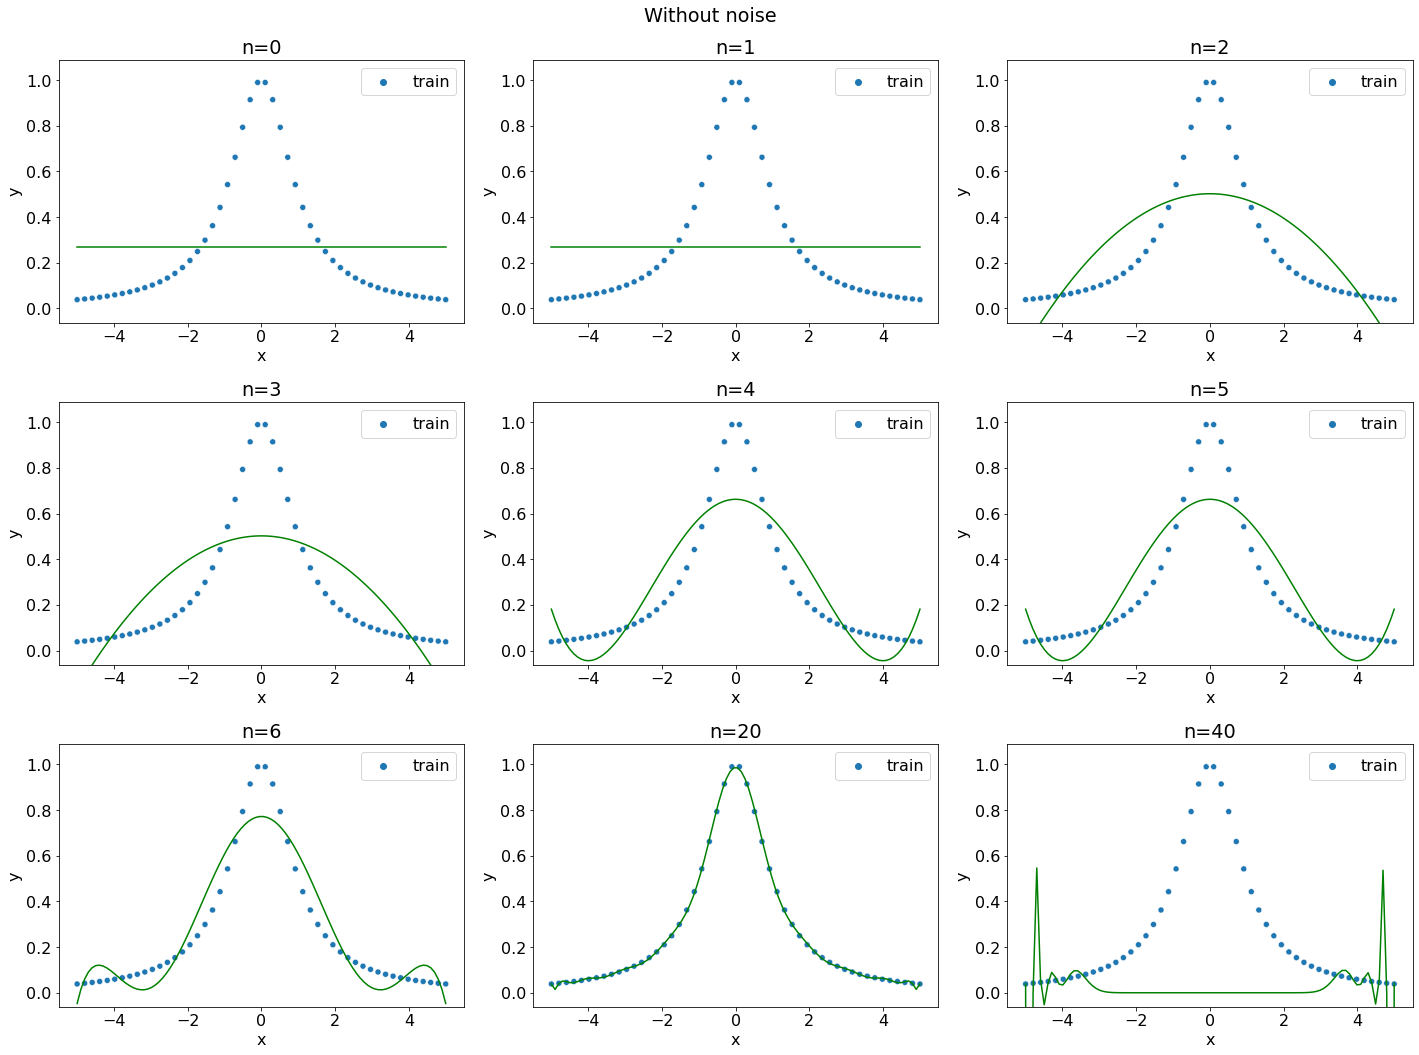

In [122]:
degrees = [0, 1, 2, 3, 4, 5, 6, 20, 40]

coefficients = {}
fig, axs = plt.subplots(figsize=(20, 15), ncols=3, nrows=3, layout="tight")
fig.suptitle("Without noise")
for ax, degree in zip(axs.flatten(), degrees):
    regressor = polynomial_regression(data, degree)
    coefficients[degree] = regressor.coef[:6] 
    plot_regression_problem(ax, data, regressor)
    ax.set_title(f"n={degree}")

coefficients["true"] = coef

with pd.option_context('display.float_format', '{:0.4f}'.format):
    df = pd.DataFrame.from_dict(coefficients, orient="index", columns=[f"x^{i}" for i in range(6)])
    print(df)

Видим, что 
- полиномами степеней 0, 1 и 2 совсем не удаётся уловить исходную зависимость $f(x) = 1 - \dfrac{x^2}{2} + \dfrac{x^4}{12}$;
- полином степени 3 в неплохой степени аппроксимирует точки выборки, но коэффициенты найденного полинома довольно сильно отличаются от исходного; 
- полином степени 4 в точности проходит через все точки выборки. Это объясняется тем, что выборка сгенерирована полиномом 4-й степени, а значит можно точно восстановить все коэффициенты полинома из выборки; 
- полиномы степеней 5, 6 и 20 находят по факту тот же самый полином четвертой степени с нулевыми коэффициентами при старших степенях, что согласуется с теорией;
- при $N=40$ не удаётся получается аппроксимация плохого качества, что объясняется погрешностью численного алгоритма решения задачи МНК.

Добавим шум к данным и посмотрим, как это повлияет на качество аппроксимации.

       x^0   x^1    x^2    x^3    x^4    x^5
2     1.03 -0.52   0.07    NaN    NaN    NaN
3     1.23 -1.01   0.35  -0.05    NaN    NaN
4     1.08 -0.39  -0.30   0.20  -0.03    NaN
5     1.14 -0.77   0.30  -0.18   0.07  -0.01
6     1.14 -0.78   0.33  -0.21   0.08  -0.01
7     0.49  5.11 -15.64  19.24 -12.16   4.13
8    -0.23 12.56 -40.51  58.19 -45.10  20.03
9     0.75  1.05   5.69 -31.34  51.46 -41.92
10    0.48  4.78 -12.58  12.75  -8.98   8.63
true  1.00  0.00  -0.50   0.00   0.04    NaN


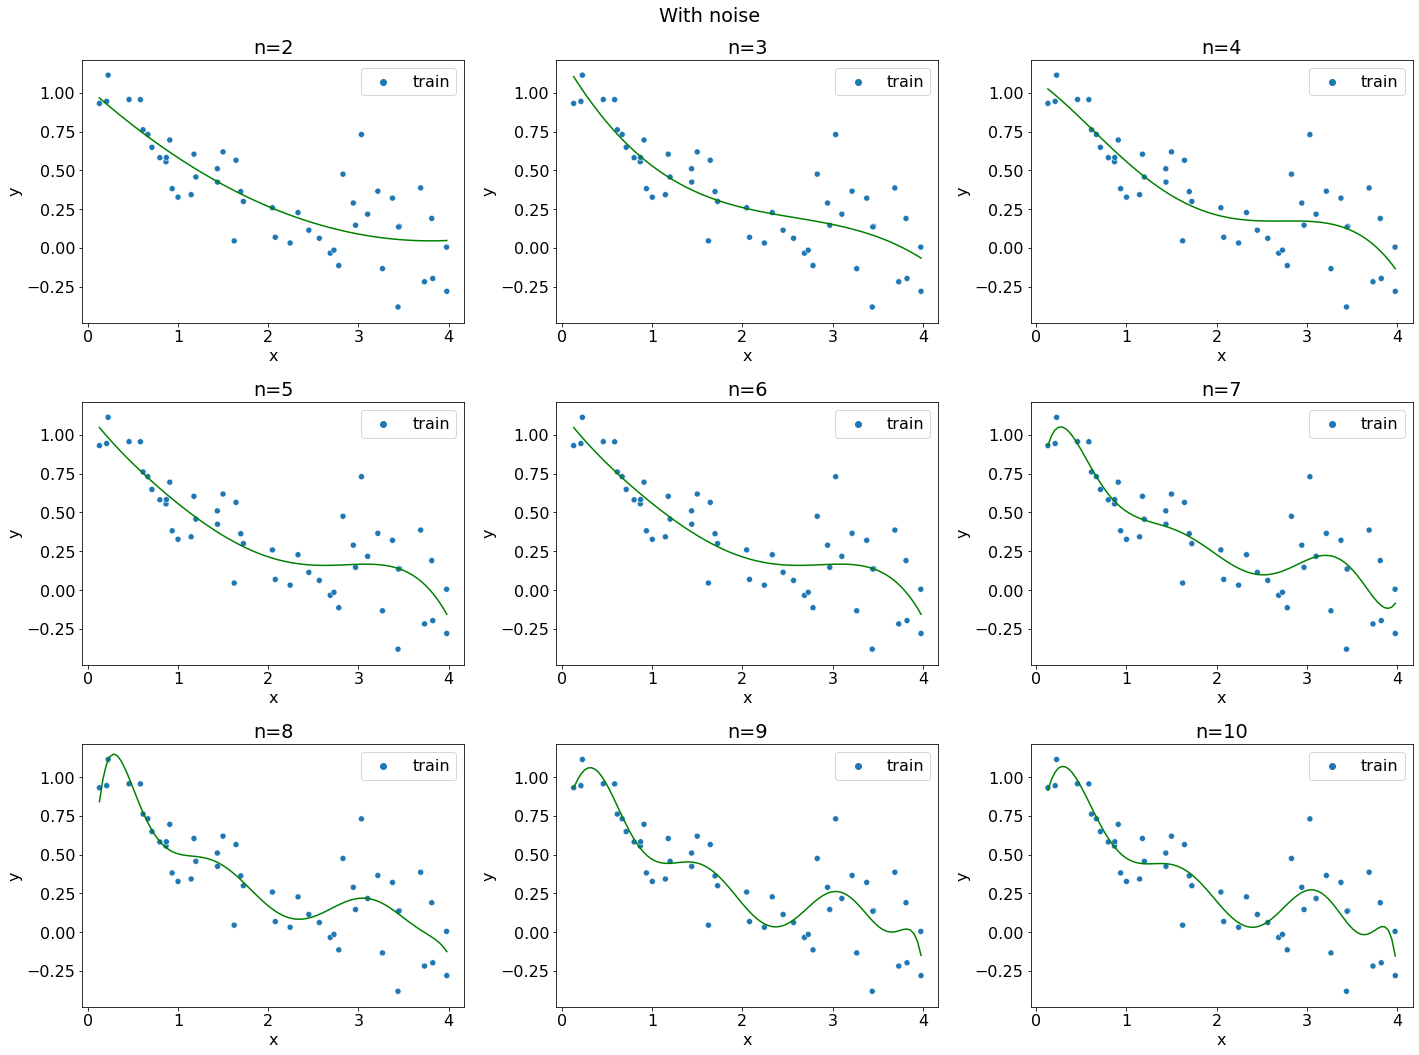

In [123]:
data = generate_problem(f, 0, 4, noise=0.2, randomize_x=True)
degrees = [2, 3, 4, 5, 6, 7, 8, 9, 10]


coefficients = {}
fig, axs = plt.subplots(figsize=(20, 15), ncols=3, nrows=3, layout="tight")
fig.suptitle("With noise")
for ax, degree in zip(axs.flatten(), degrees):
    regressor = polynomial_regression(data, degree)
    coefficients[degree] = regressor.coef[:6]
    
    plot_regression_problem(ax, data, regressor)
    ax.set_title(f"n={degree}")
    
coefficients["true"] = coef

with pd.option_context('display.float_format', '{:0.2f}'.format):
    df = pd.DataFrame.from_dict(coefficients, orient="index", columns=[f"x^{i}" for i in range(6)])
    print(df)

В этот раз коэффициенты исходного полинома не удалось толком восстановить, но все кривые при $N>3$ довольно неплохо проходят через всю выборку, хотя коэффициенты каждого полинома довольно сильно разнятся. Какой из полиномов выбрать? Какой полином лучше описывает исходную зависимость $x$ от $y$?

До сих пор выборка генерировалась вокруг кривой, которая сама по себе являлась полиномом. Рассмотрим [феномен Рунге](https://ru.wikipedia.org/wiki/%D0%A4%D0%B5%D0%BD%D0%BE%D0%BC%D0%B5%D0%BD_%D0%A0%D1%83%D0%BD%D0%B3%D0%B5) на другой функции

$$
f(x) = \dfrac{1}{1 + x^2}.
$$

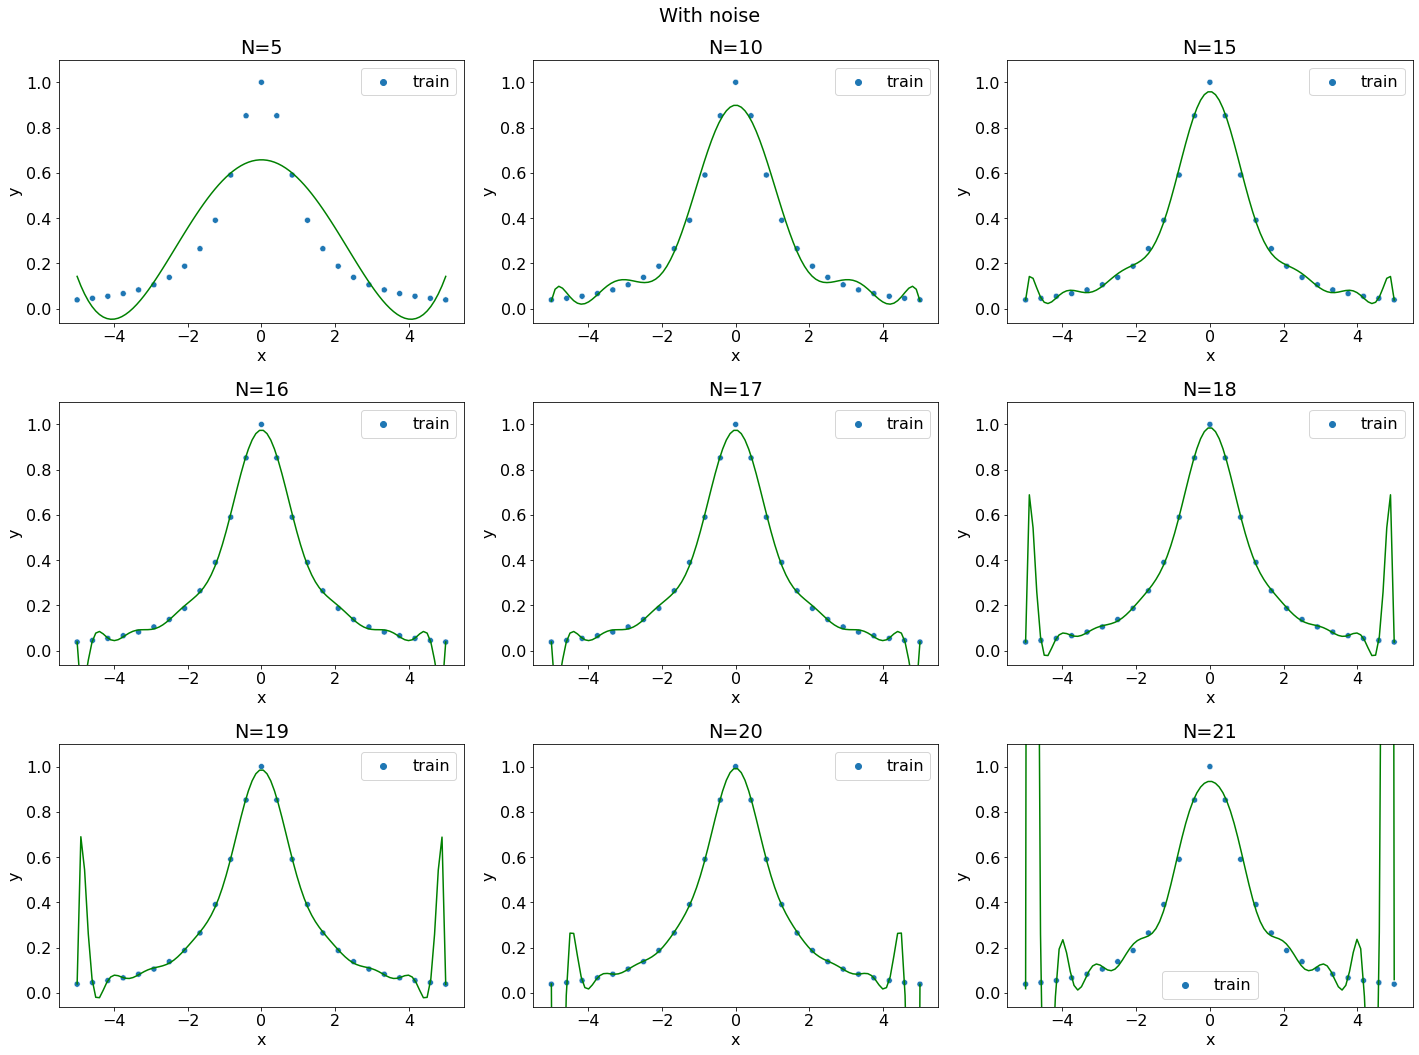

In [119]:
def f(x):
    return 1./(1. + x**2)

data = generate_problem(f, -5, 5, n=25)

degrees = (5, 10, 15, 16, 17, 18, 19, 20, 21)

fig, axs = plt.subplots(figsize=(20, 15), ncols=3, nrows=3, layout="tight")
fig.suptitle("With noise")
for ax, degree in zip(axs.flatten(), degrees):
    regressor = polynomial_regression(data, degree)
    
    plot_regression_problem(ax, data, regressor)
    ax.set_title(f"N={degree}")

Несмотря на отсутствие шума аппроксимация полиномом высокой степени приводит к нерегулярным решениям на краях. Полином очень близко проходит ко всем точкам выборки, но выдаёт сомнительные значения между ними.

## Валидационная выборка. Недообучение и переобучение

Одна из идей машинного обучения с учителем заключается в следующем: нам не столько интересно насколько хорошо кривая аппроксимирует те точки, под которые мы её подгоняли, а гораздо интереснее обобщающая способность этой кривой, т.е. насколько хорошо эта кривая проходит к тем точкам, которые не никоим образом не использовались для подгонки кривой. 

Процесс подбора параметров кривой на основе выборки называют обучением, а саму эту выборку называют обучающей выборкой. Как уже было замечено, нас интересует качество модели на не попавших в обучающую выборку объектах. Т.к. обычно доступная выборка ограниченна, то часто доступную выборку делят на две непересекающиеся  части, на одной из которых производят обучение, а на другой тестируют качество модели.  

В ячейке эта схема применяется к тому же набору точек. На половине точек подбираются коэффициенты полиномов, но на графике выводятся оба половины выборки. 

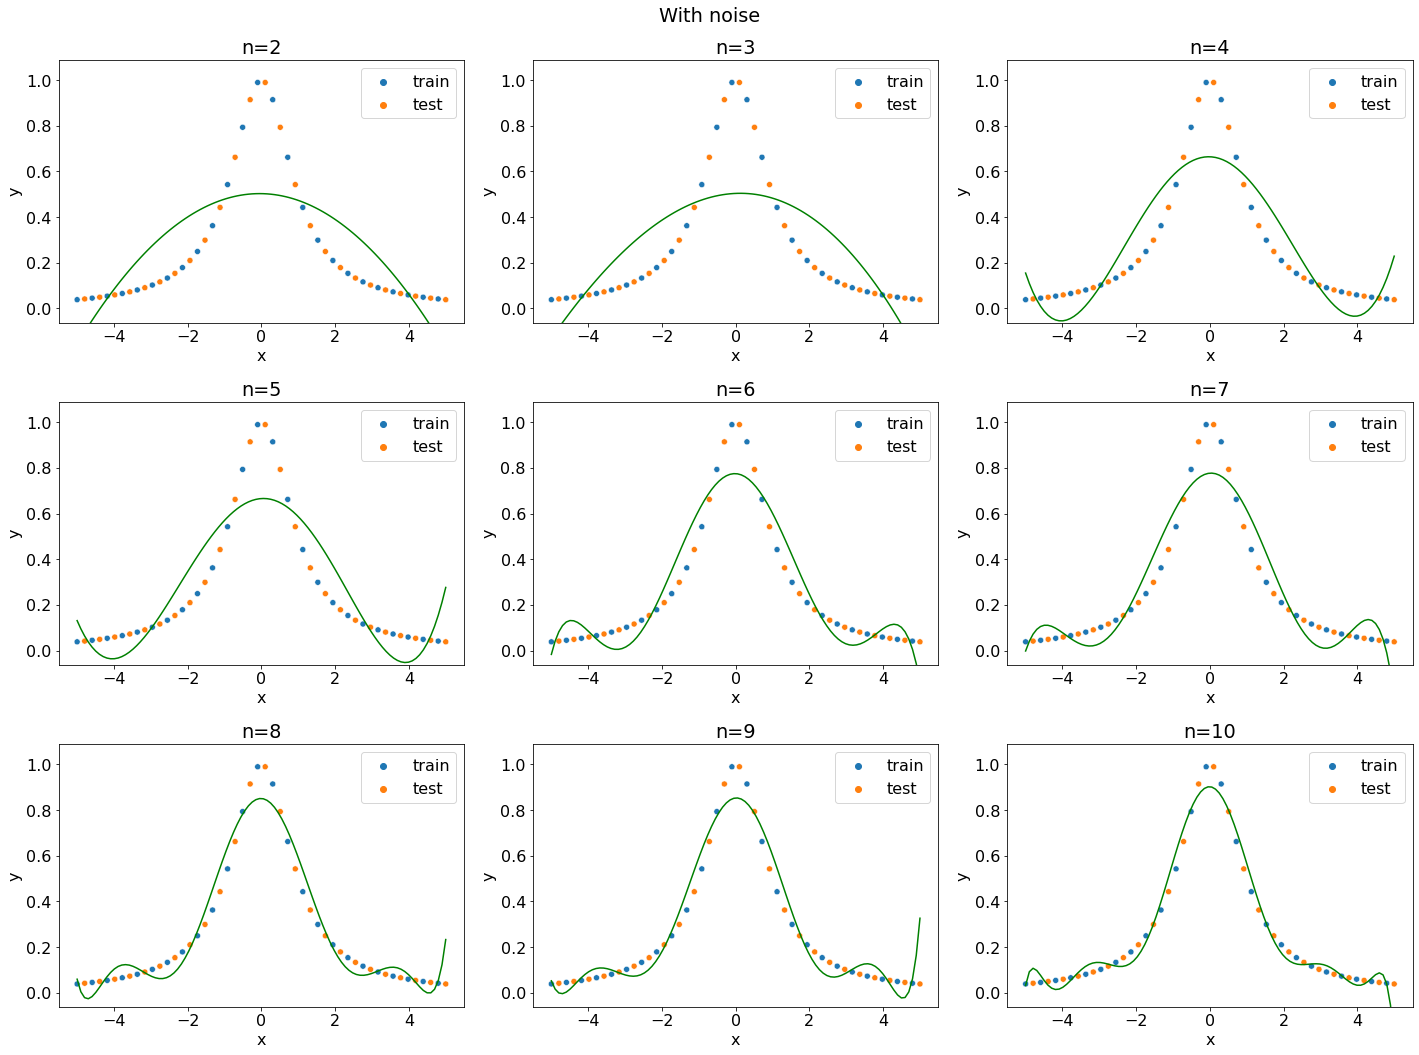

In [124]:
data = generate_problem(f, -5, 5, n=50)
train_data, test_data = data.iloc[::2], data.iloc[1::2]

fig, axs = plt.subplots(figsize=(20, 15), ncols=3, nrows=3, layout="tight")
fig.suptitle("With noise")
for ax, degree in zip(axs.flatten(), degrees):
    regressor = polynomial_regression(train_data, degree)
    plot_regression_problem(ax, train_data, regressor, test_data)
    ax.set_title(f"n={degree}")

Заметим, что при больших $N$ кривая проходит близко к точкам обучающей выборки, но далеко от точек валидационной. 

(0.0, 0.4)

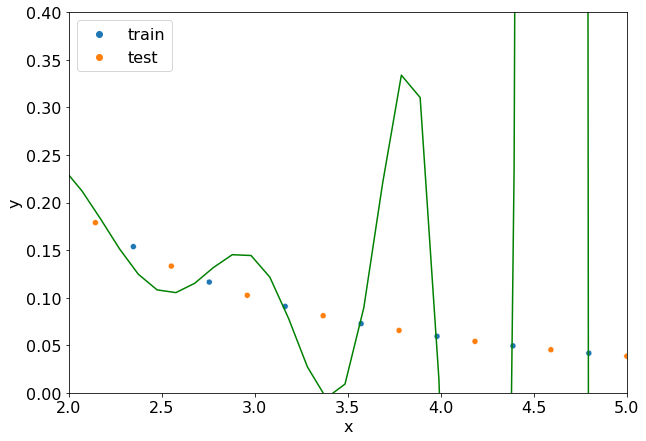

In [125]:
fig, ax = plt.subplots(figsize=(10, 7))
regressor = polynomial_regression(train_data, degree=21)
plot_regression_problem(ax, train_data, regressor, test_data)
ax.set_xlim(2, 5)
ax.set_ylim(0, 0.4)

Рассмотрим две крайние ситуации.
1. Алгоритм плохо аппроксимирует и точки обучающей выборки и точки тестовой выборки. Такой эффект называют **недообучением** (underfitting) и его можно наблюдать на графиках при малых $n$. Недообучение часто связывают с слишком простым семейством моделей: полинома 5-й степени просто недостаточно, для того чтобы хоть как-то аппроксимировать кривую $1./(1 + x^2)$.
2. Алгоритм хорошо аппроксимирует точки обучающей выборки, но плохо точки тестовой выборки. Такой эффект называют **переобучением** (overfitting) и его можно наблюдать при больших $b$. Переобучение часто связывают с слишком сложной моделью: полином высокой степени можно провести через все точки обучающей выборки, т.е. полином может её как-бы запомнить. 

В реальных задачах редко можно обучающую выборку. Например, пространство признаков может быть многомерным. В таких ситуациях эффекты обучения/переобучения пытаются обнаружить с помощью подсчета метрик на обучающей и валидационной выборках. Если модель демонстрирует плохие показатели на обеих выборках, то скорее всего алгоритм недообучился, а если алгоритм показывает хорошие показатели на тренировочной выборке, но плохие на валидационной, то скорее всего алгоритм переобучился.  

Построим график зависимости среднеквадратичной ошибки в зависимости на обучающей и тестовой выборках в зависимости от степени полинома.

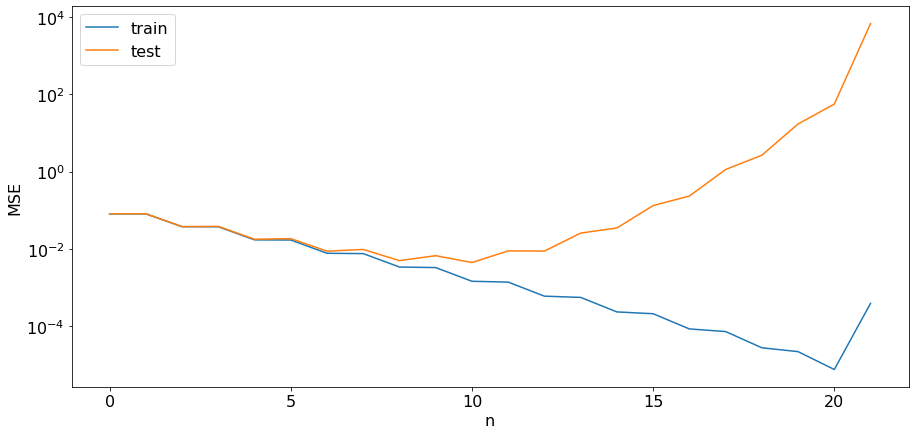

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def evaluate_mse(regressor, data):
    y_pred = regressor(data["x"])
    y_true = data["y"]
    return mean_squared_error(y_true, y_pred)



train_mse = []
test_mse = []
for degree in range(22):
    regressor = polynomial_regression(train_data, degree)
    train_mse.append(evaluate_mse(regressor, train_data))
    test_mse.append(evaluate_mse(regressor, test_data))


fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(train_mse, label="train")
ax.set_yscale("log")
ax.plot(test_mse, label="test")
ax.set_xlabel("n")
ax.set_ylabel("MSE")
ax.legend()


При $n$ от 1 до примерно 5 погрешность на обучающей и валидационной выборках примерно совпадает, но при увеличении $N$ погрешность падает. Из этого можно сделать вывод, что алгоритм недообучился. При $n$ больших 10 погрешность продолжает падать на обучающей выборке, но не на тестовой, что сигнализирует о переобучении. Оптимальное значение $n$ находится где-то по середине.